In [1]:
import torch
import torch.optim as optim
from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from src.flows import ContinuousFlow
from src.utils import get_two_moons_data

# --- 1. Configuration ---
input_dim = 2
hidden_dim = 128
learning_rate = 1e-3
n_epochs = 1000
batch_size = 1024
n_samples = 10000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = get_two_moons_data(n_samples=n_samples).to(device)
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

base_dist = MultivariateNormal(torch.zeros(input_dim, device=device), torch.eye(input_dim, device=device))

# --- 2. Model and Optimizer ---
model = ContinuousFlow(dim=input_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [2]:
# --- 3. Training ---
print("Starting training for Continuous Normalizing Flow...")
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for x in data_loader:
        optimizer.zero_grad()
        # For CNFs, we don't have a direct log-determinant, so we use a different loss
        # A common approach is to use the Hutchinson's trace estimator, but for simplicity,
        # we can use a proxy loss, like maximum likelihood on the transformed variable.
        z = model.inverse(x)
        loss = -base_dist.log_prob(z).mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {total_loss / len(data_loader):.4f}')
print("Training finished.")


Starting training for Continuous Normalizing Flow...
Epoch 100/1000, Loss: 1.8379
Epoch 200/1000, Loss: 1.8379
Epoch 300/1000, Loss: 1.8379
Epoch 400/1000, Loss: 1.8379
Epoch 500/1000, Loss: 1.8379
Epoch 600/1000, Loss: 1.8379
Epoch 700/1000, Loss: 1.8379
Epoch 800/1000, Loss: 1.8379
Epoch 900/1000, Loss: 1.8379
Epoch 1000/1000, Loss: 1.8379
Training finished.


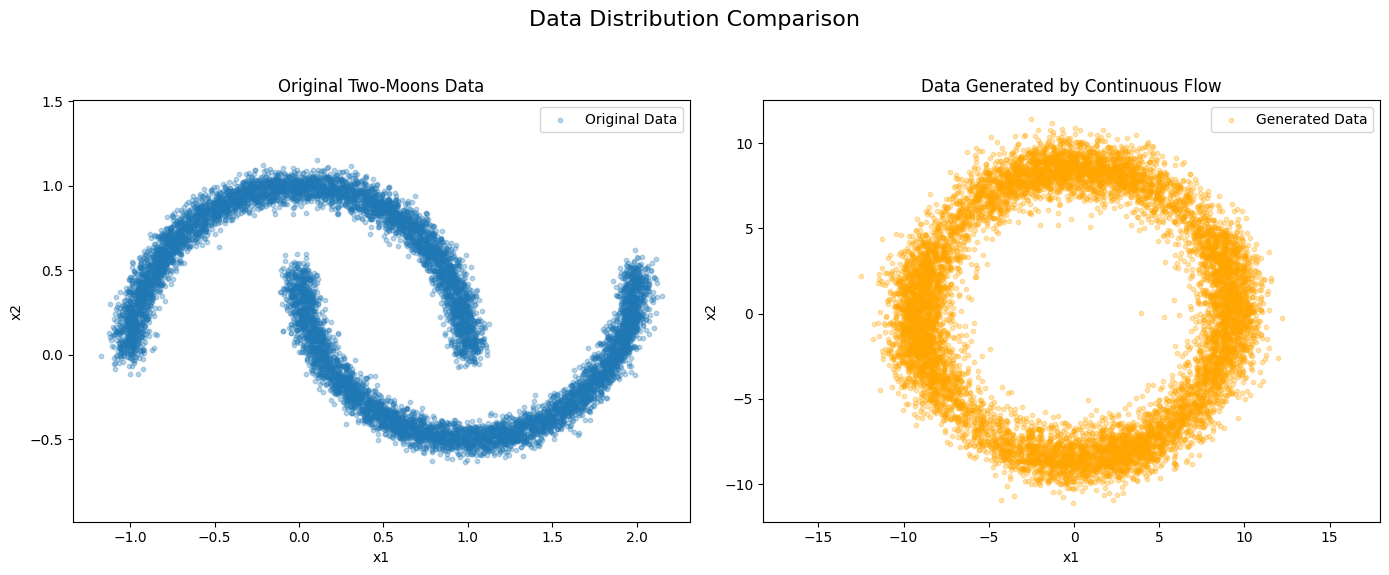

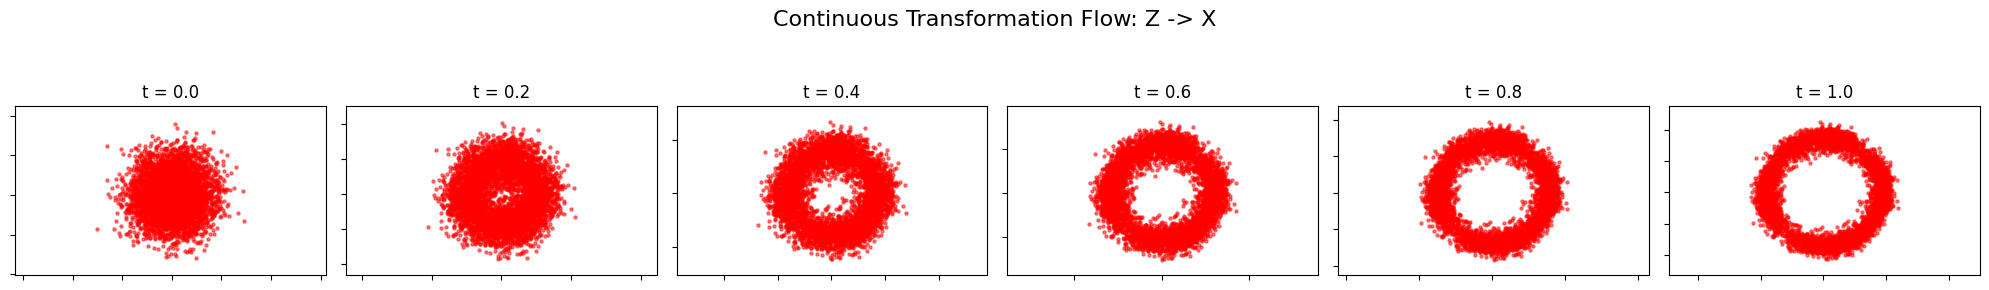

In [3]:

# --- 4. Visualization ---
model.eval()
with torch.no_grad():
    # a) Plot generated samples vs. original data
    plt.figure(figsize=(14, 6))

    # Original Data
    plt.subplot(1, 2, 1)
    plt.scatter(data.cpu()[:, 0], data.cpu()[:, 1], s=10, alpha=0.3, label='Original Data')
    plt.title('Original Two-Moons Data')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.axis('equal')

    # Generated Data
    plt.subplot(1, 2, 2)
    z_samples = base_dist.sample((n_samples,))
    x_generated = model.forward(z_samples).cpu().numpy()
    plt.scatter(x_generated[:, 0], x_generated[:, 1], s=10, alpha=0.3, c='orange', label='Generated Data')
    plt.title('Data Generated by Continuous Flow')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.axis('equal')

    plt.suptitle('Data Distribution Comparison', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # b) Visualize the "flow"
    n_points = 5000
    z_grid = base_dist.sample((n_points,))
    
    # Define time points for visualization
    time_points = torch.linspace(0, 1, 6)
    
    fig, axes = plt.subplots(1, len(time_points), figsize=(20, 3))
    
    for i, t in enumerate(time_points):
        # Integrate from 0 to t
        x_flow = model.forward(z_grid, integration_times=torch.tensor([0, t]))
        axes[i].scatter(x_flow.cpu()[:, 0], x_flow.cpu()[:, 1], s=5, c='r', alpha=0.5)
        axes[i].set_title(f"t = {t:.1f}")
        axes[i].axis('equal')
        axes[i].set_yticklabels([])
        axes[i].set_xticklabels([])

    fig.suptitle('Continuous Transformation Flow: Z -> X', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.9])
    plt.show()